# **합성곱 신경망(CNN)**

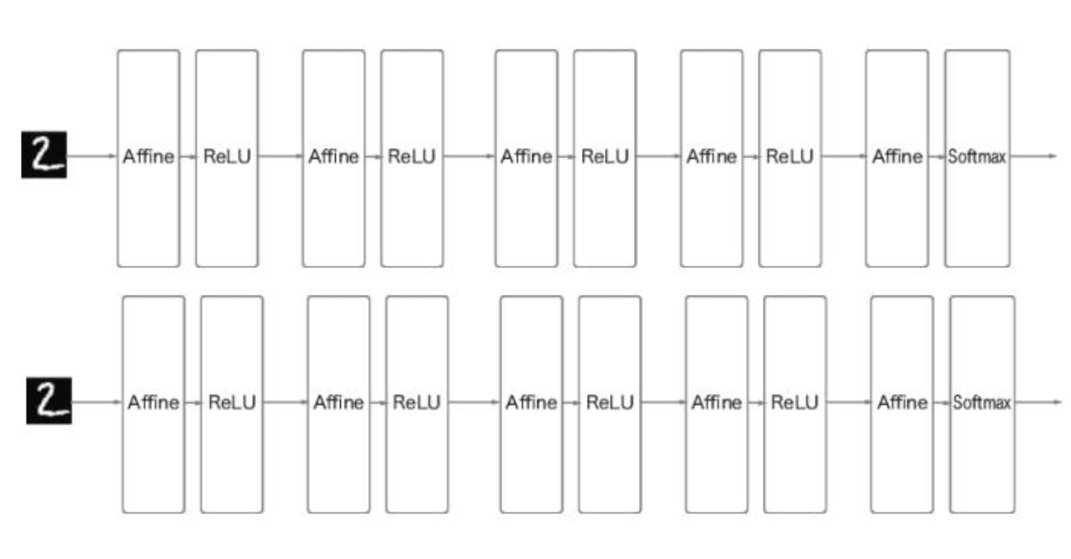

CNN에서는 합성곱 계층의 입출력 데이터를 특징맵이라고 한다.
입력데이터: 입력 특징 맵(input feature map)
출력데이터: 출력 특징맵(output feature map)

# **합성곱 연산 계층(convolutional layer)**

* 합성곱 연산의 예
(단일 곱센-누산)

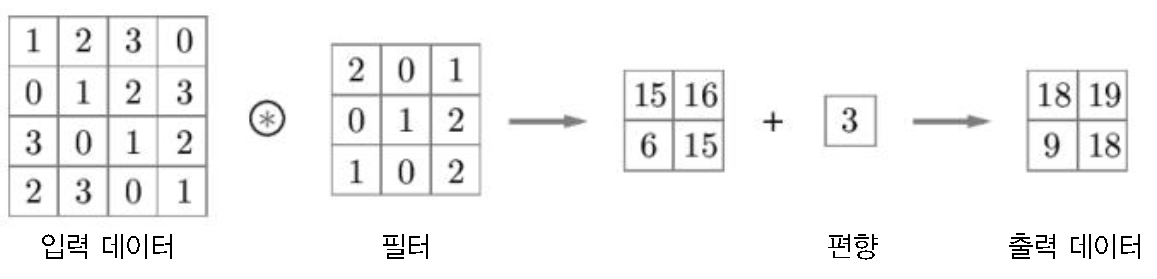

* 패딩

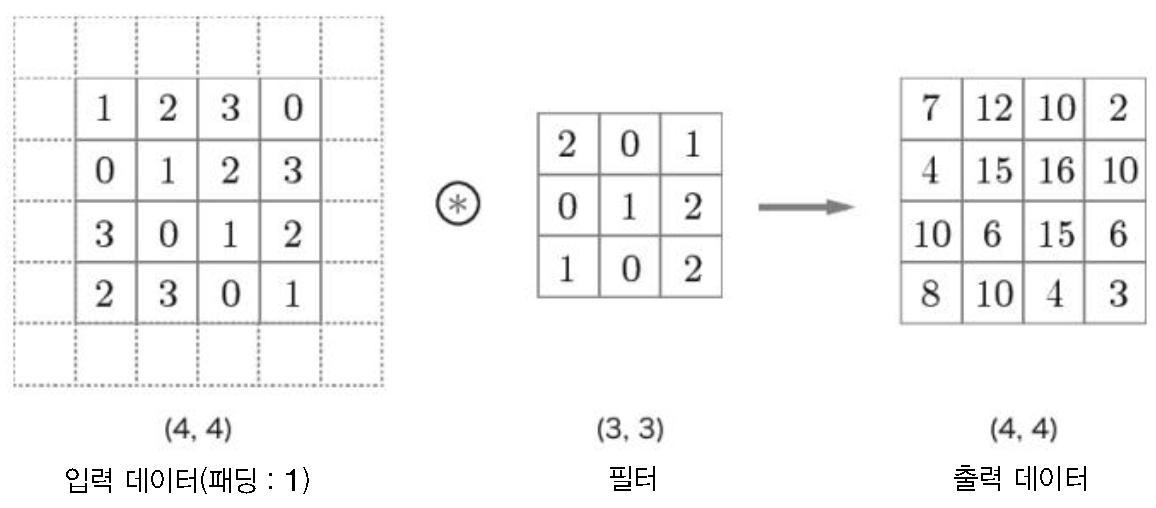

* 스트라이드(stride)

필터를 적용하는 위치의 간격


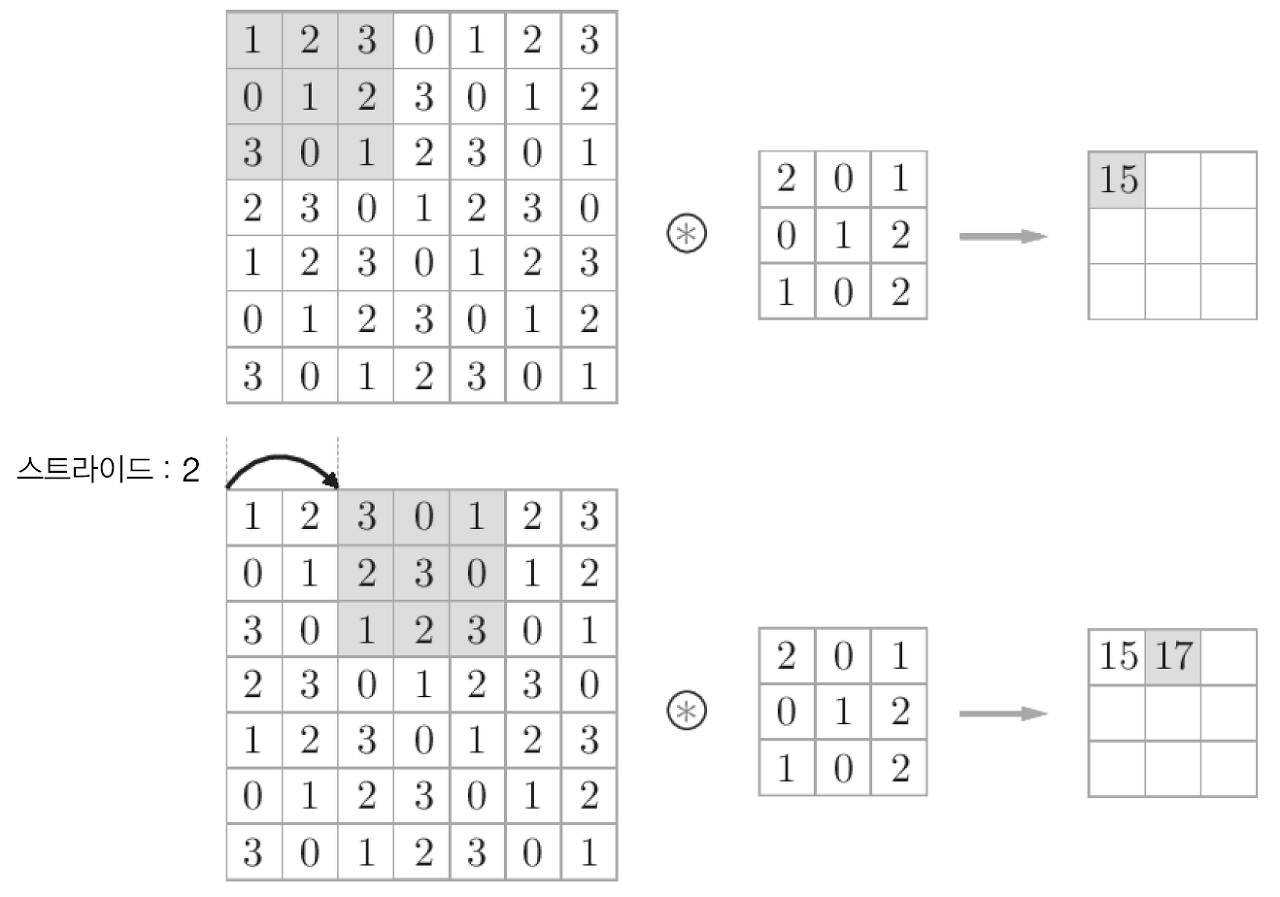

출력 특징맵 크기 구하기

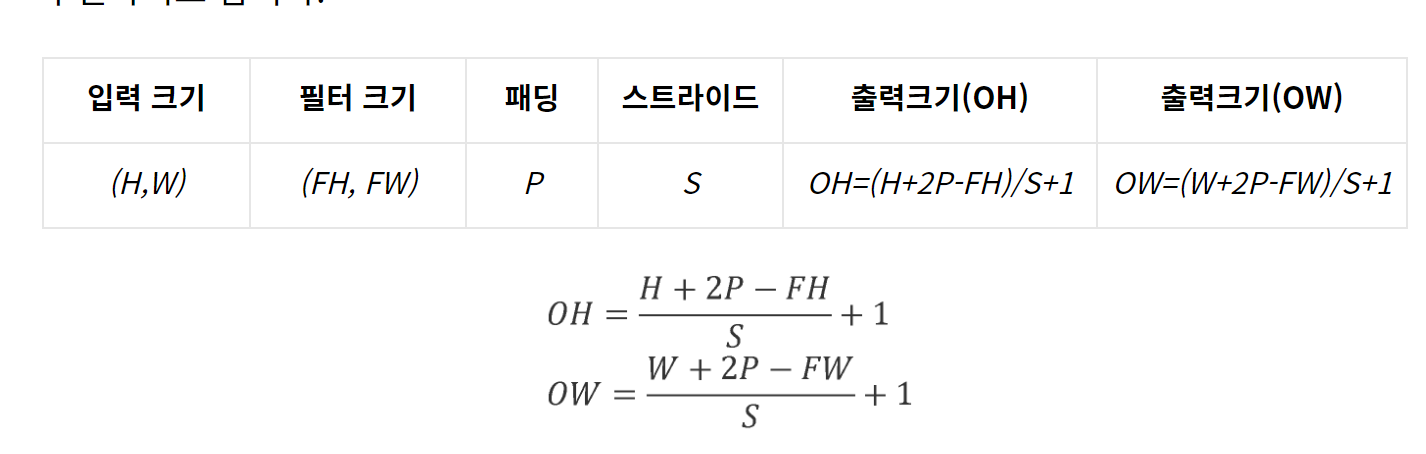

# **3차원 합성곱 연산**

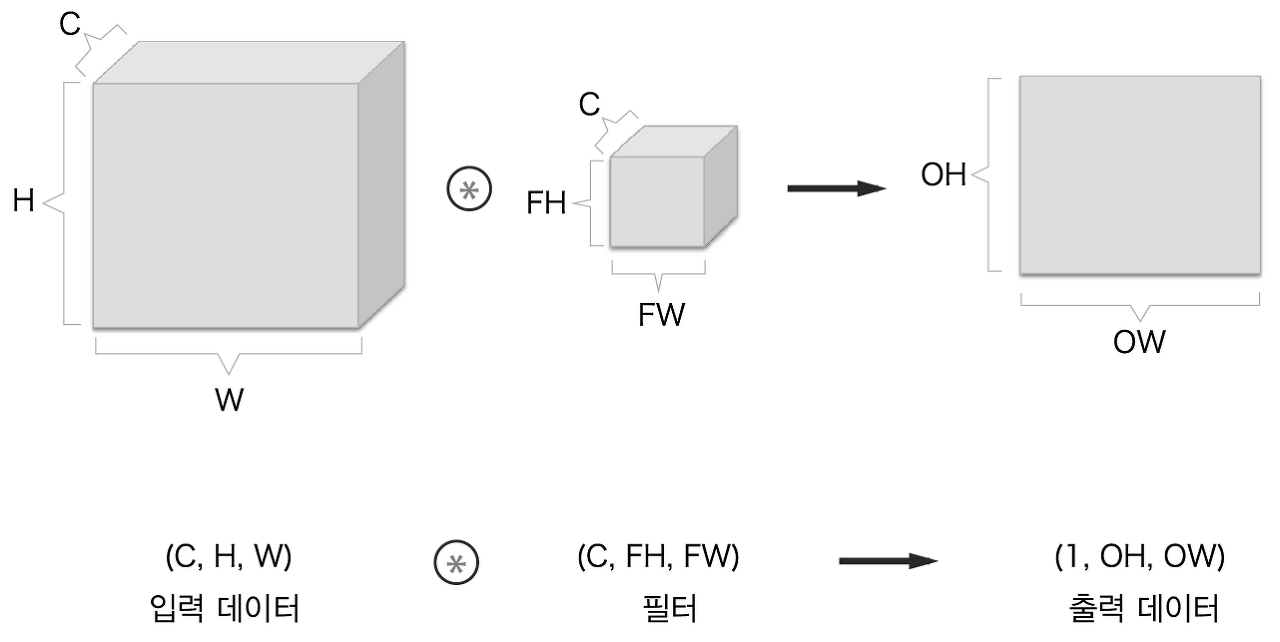

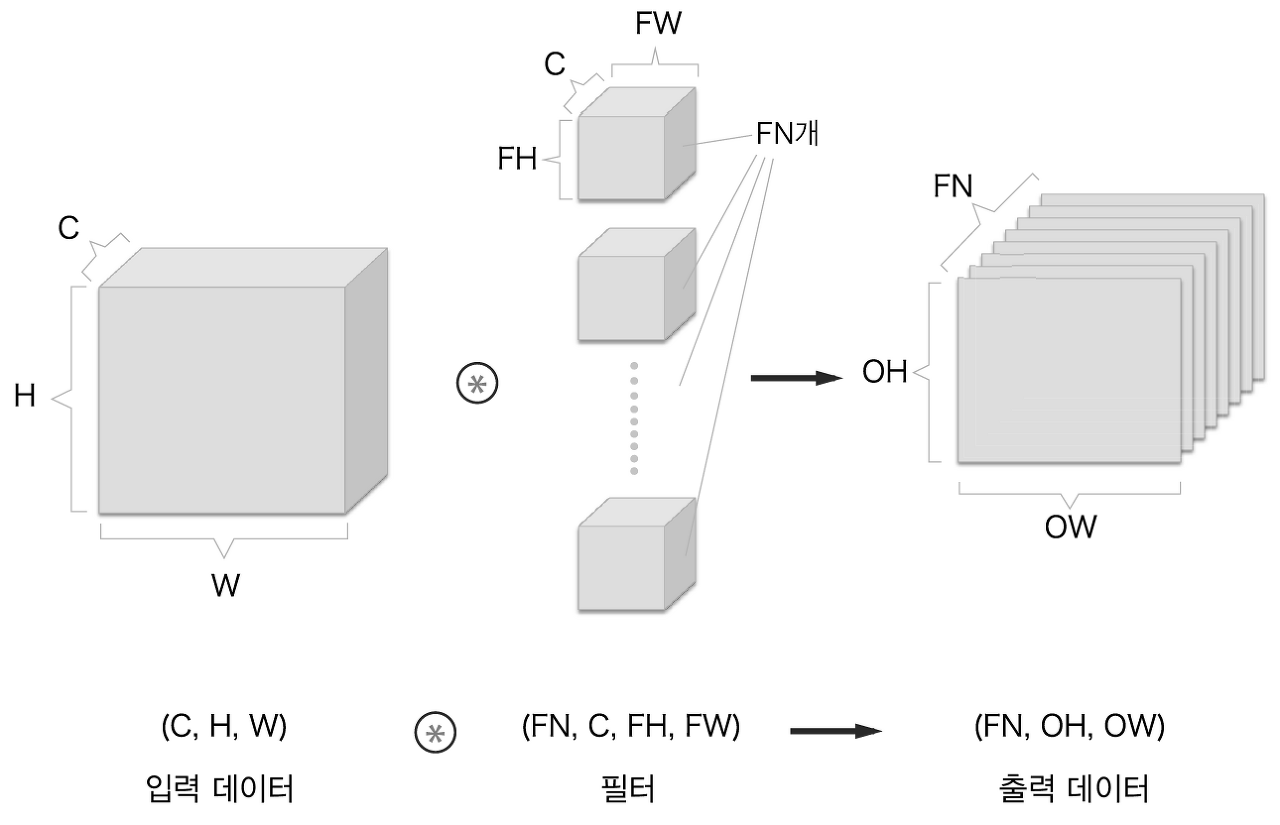

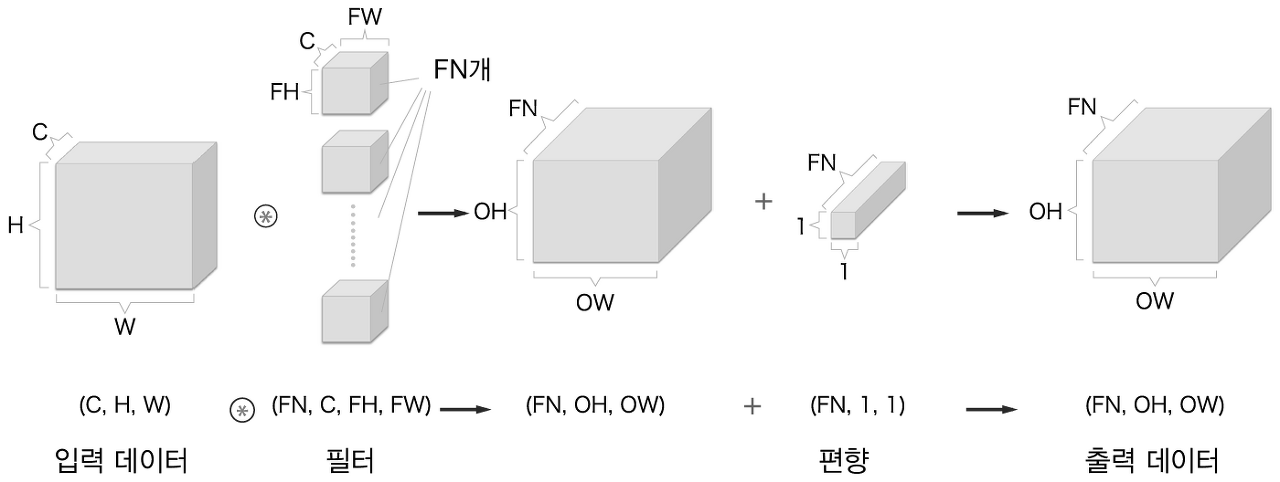

# **풀링 계층**

세로, 가로 방향의 공간을 줄이는 연산

- 특징

1. 학습해야 할 매개변수가 없다
2. 채널 수가 변하지 않는다
3. 입력의 변화에 영향을 적게 받는다(강건하다)

- 종류

1. 최대 풀링(Max pooling)
: 풀링 영역내의 최대값을 구하는 연산
2. 평균 풀링(Average pooling)
: 풀링 영역의 평균을 계산하는 연산


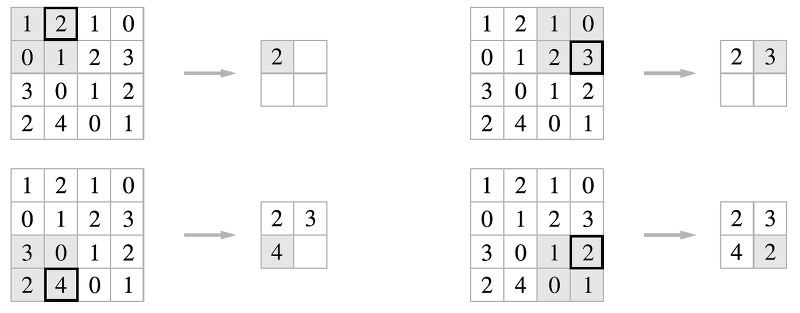

# 합성곱/풀링 계층 구현하기

In [ ]:
import numpy as np

# 4차원 배열 (데이터, 체널, 높이, 너비)
x = np.random.rand(10,1,28,28)
x.shape


(10, 1, 28, 28)

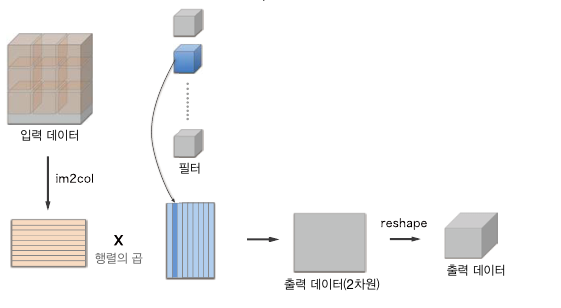

In [ ]:
ef im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다.

    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩

    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [ ]:
class Convolution:
	def __init__(self, W, b, stride=1, pad=0):
            self.W = W   # 필터(가중치)
            self.b = b   # 편향 bias
            self.stride = stride  #스트라이드
            self.pad = pad   #패딩

	def forward(self,x):
            FN, C, FH, FW = self.W.shape   #필터 개수, 채널, 필터 높이, 필터 너비
            N, C, H, W = x.shape
            out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
            out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

            col = im2col(x, FH, FW, self.stride, self.pad)  # 입력 데이터 전개
            col_W = self.W.reshape(FN, -1).T  # 2차원 배열로 필터 전개
            out = np.dot(col, col_W) + self.b  # 전개된 두 행렬의 곱

            out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
            # (N, H, W, C)  --->  (N, C, H, W)
            #  0, 1, 2, 3   --->   0, 3, 1, 2  로 transpose 이용해서 인덱스로 축 순서 변경해줌

            return out

위 코드에서 reshape(FN, -1)에 대해 설명하고 지나가겠습니다.

원래 self.W인 필터는 (FN, C, FH, FW)의 4차원 형상입니다.
reshape 함수를 이용해서 2차원 배열인 (FN, -1)로 전개하게 한다는 것은
결국 (FN, FN*C*FH*FW/FN) 의 형상의 배열로 만들어준다는 얘기가 됩니다.

더 이해가 잘 가도록 예를 들어서, A = (10, 5, 4, 3)의 형상을 한 다차원 배열 A가 있다고 합시다.
배열 A의 총 원소의 수는 10*5*4*3=600개죠?

A.reshape(10, -1)는 (10, 60)의 형상을 가진 배열로 만들어주면서
형상이 변환된 후에도 원소 수가 똑같이 유지가 됩니다.

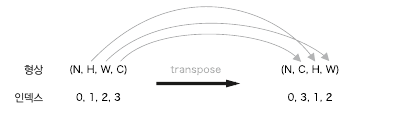

# 풀링 계층 구현

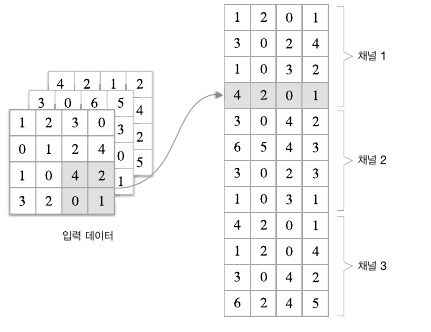

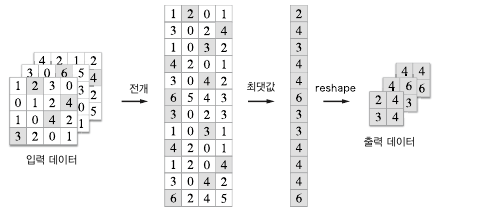

In [ ]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad =0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1+(H-self.pool_h)/self.stride)
        out_w = int(1+(W-self.pool_w)/self.stride)

        # 전개(1)
        col = im2col(x, self.pool_h, self.pool_w, stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        # 최댓값(2)
        out = np.max(col, axis=1) # 가로 전개

        # 성형(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out